In [14]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [15]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [16]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "training",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [17]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [18]:
len(dataset)

68

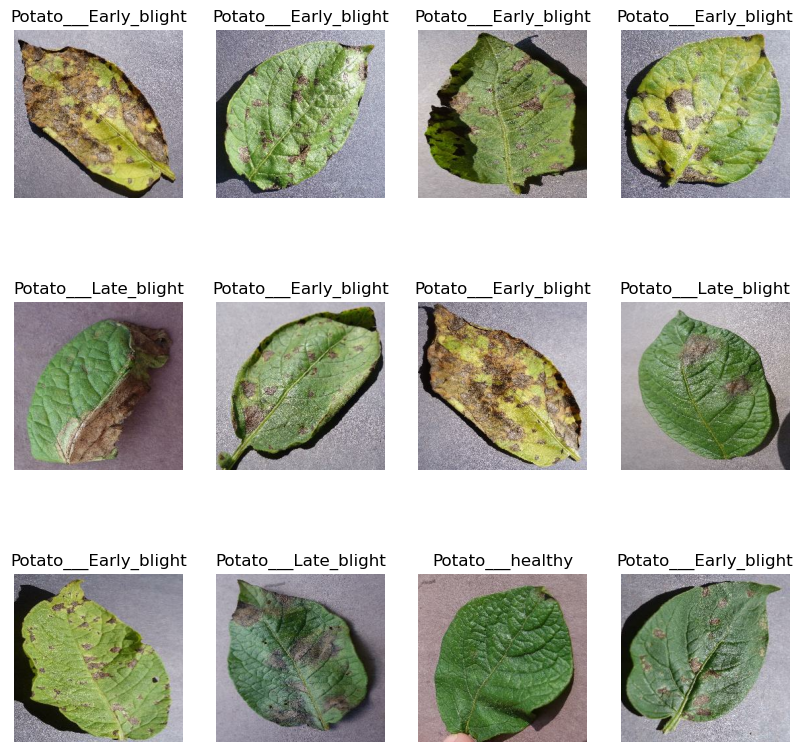

In [19]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [20]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [21]:
train_ds = dataset.take(54)

In [22]:
test_ds = dataset.skip(54)

In [23]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [24]:
val_ds = test_ds.take(6)

In [25]:
test_ds = test_ds.skip(6)

In [81]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [82]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset, shuffle=False)

In [83]:
len(train_ds)

54

In [84]:
len(val_ds)

6

In [85]:
len(test_ds)

8

In [89]:
#how many numbers of images of each class in the training, validation and testing dataset

early = np.array([0])
late = np.array([1])
healthy = np.array([2])

early_tensor = tf.constant(early)
late_tensor = tf.constant(late)
healthy_tensor = tf.constant(healthy)

healthy_num, late_num, early_num = 0, 0, 0

for image_batch, label_batch in train_ds:
    # Get the unique labels in the current batch
    unique_labels = np.unique(label_batch.numpy())
    
    # Count occurrences of each class
    for label in unique_labels:
        if label == 2:  # Healthy class
            healthy_num += np.sum(label_batch.numpy() == label)
        elif label == 0:  # Early class
            early_num += np.sum(label_batch.numpy() == label)
        elif label == 1:  # Late class
            late_num += np.sum(label_batch.numpy() == label)
print("Healthy: ", healthy_num, " Early num: ", early_num, " Late num: ", late_num)

Healthy:  120  Early num:  795  Late num:  813


In [ ]:
# a = np.array([0, 0, 1])
# b = np.array([1])
# tensor_a = tf.constant(a)
# tensor_b = tf.constant(b)
# print('tensor_a: ', tensor_a)
# print('tensor_b: ', tensor_b)
# print('tensor_a[2]: ', tensor_a[2])

# if(tensor_a[2] == tensor_b):
#     print("They are equal")

In [ ]:
['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.1),
])

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape = input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 11s 104ms/step - loss: 0.8982 - accuracy: 0.5046 - val_loss: 0.8143 - val_accuracy: 0.5521
Epoch 2/50
54/54 [==============================] - 5s 88ms/step - loss: 0.5899 - accuracy: 0.7350 - val_loss: 0.5786 - val_accuracy: 0.7865
Epoch 3/50
54/54 [==============================] - 5s 88ms/step - loss: 0.4086 - accuracy: 0.8310 - val_loss: 0.4769 - val_accuracy: 0.7760
Epoch 4/50
54/54 [==============================] - 5s 87ms/step - loss: 0.2750 - accuracy: 0.8906 - val_loss: 0.1950 - val_accuracy: 0.9323
Epoch 5/50
54/54 [==============================] - 5s 86ms/step - loss: 0.1442 - accuracy: 0.9416 - val_loss: 0.1387 - val_accuracy: 0.9531
Epoch 6/50
54/54 [==============================] - 5s 87ms/step - loss: 0.1364 - accuracy: 0.9514 - val_loss: 0.6197 - val_accuracy: 0.7500
Epoch 7/50
54/54 [==============================] - 5s 87ms/step - loss: 0.1456 - accuracy: 0.9468 - val_loss: 0.2883 - val_accuracy: 0.9219
Epoch 8/50


In [25]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 16ms/step - loss: 0.1588 - accuracy: 0.9453


In [26]:
scores

[0.15881064534187317, 0.9453125]

In [27]:
history

In [28]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

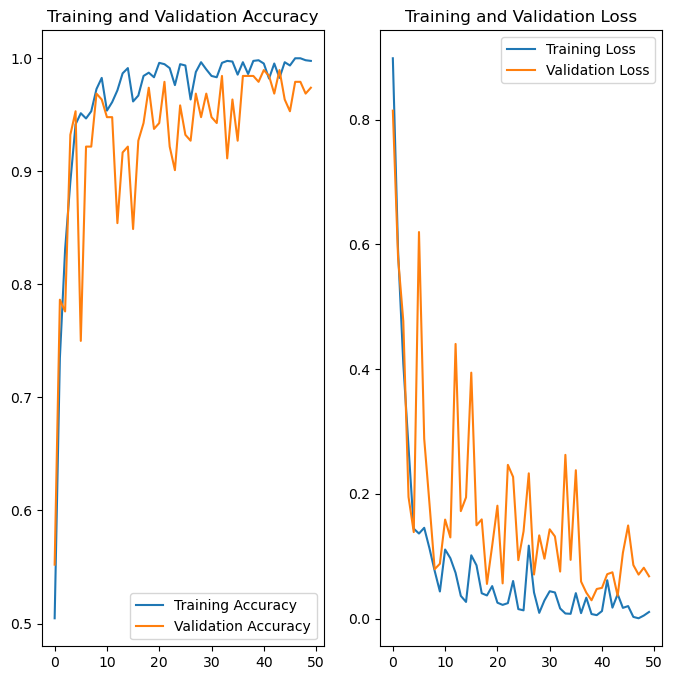

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
first image's actual label: Potato___healthy
1/1 [==============================] - 0s 84ms/step
predicted label:  Potato___Late_blight


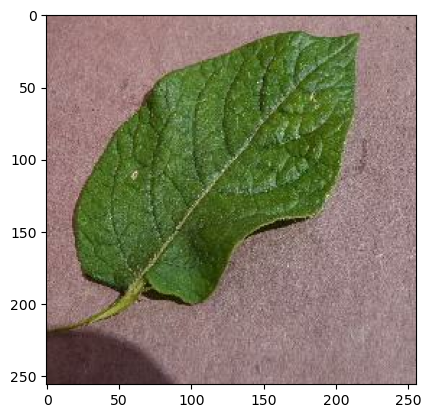

In [32]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]

    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label: ", class_names[np.argmax(batch_prediction[0])])

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 12ms/step


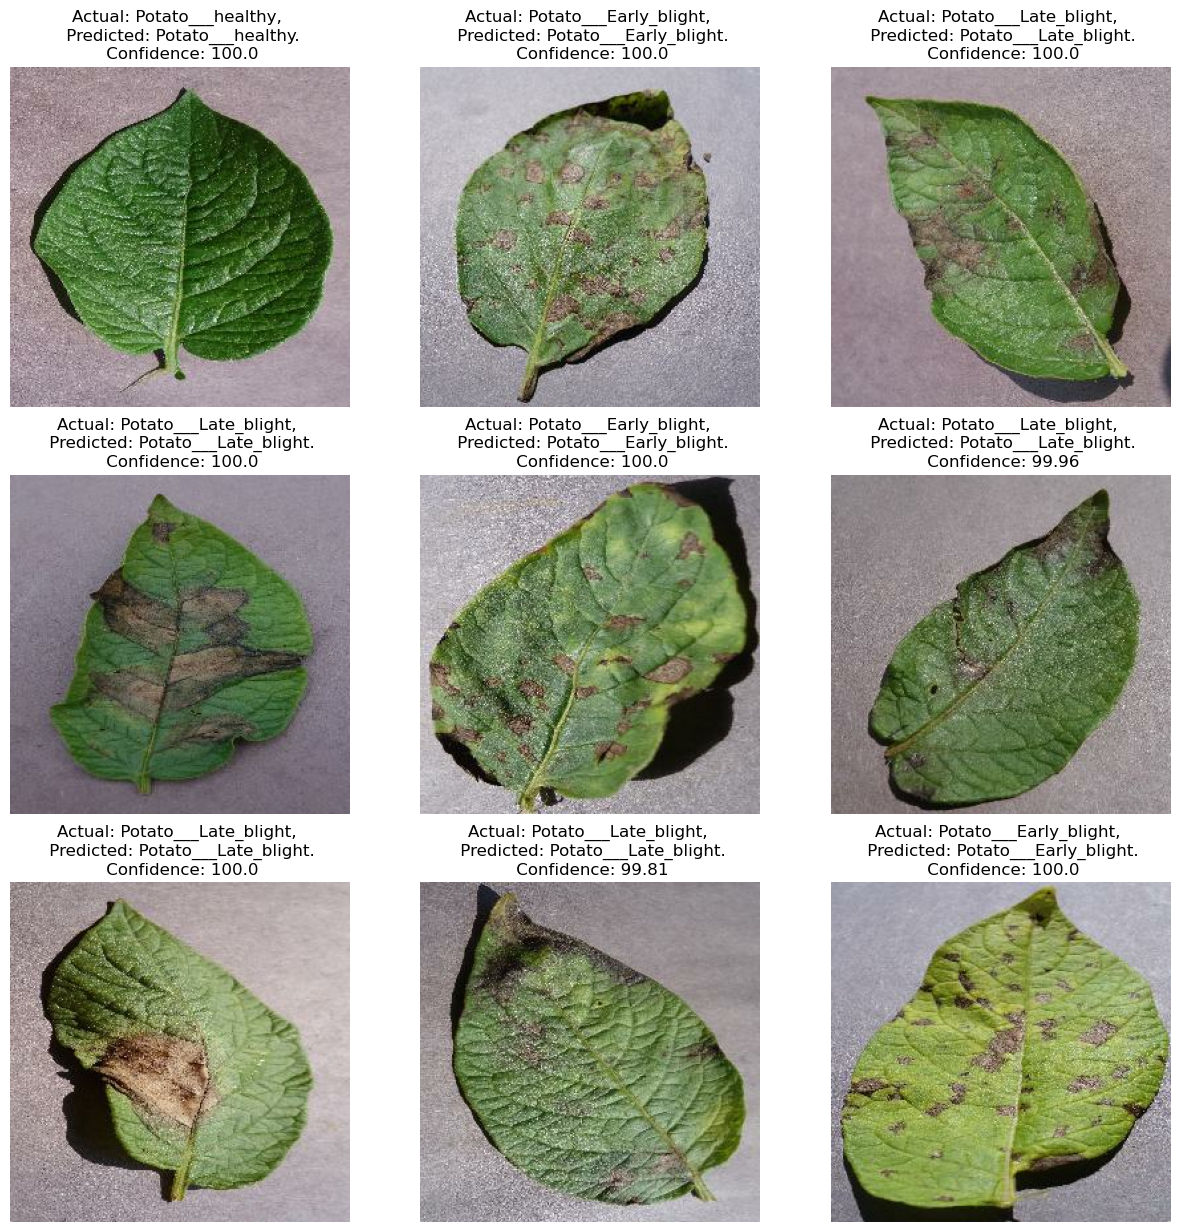

In [34]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}")
        plt.axis('off')

In [35]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [36]:
model.save('my_model.h5')

In [7]:
#finding the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

In [9]:
model = load_model('potato.h5')

In [10]:
test_dir = 'training'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),  # Set your image dimensions
    batch_size=1,
    class_mode='categorical',
    shuffle=False  # Important: Do not shuffle for confusion matrix
)

Found 2152 images belonging to 3 classes.


In [11]:
true_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

2152/2152 [==============================] - 3s 1ms/step


In [12]:
cm = confusion_matrix(true_labels, predicted_labels)

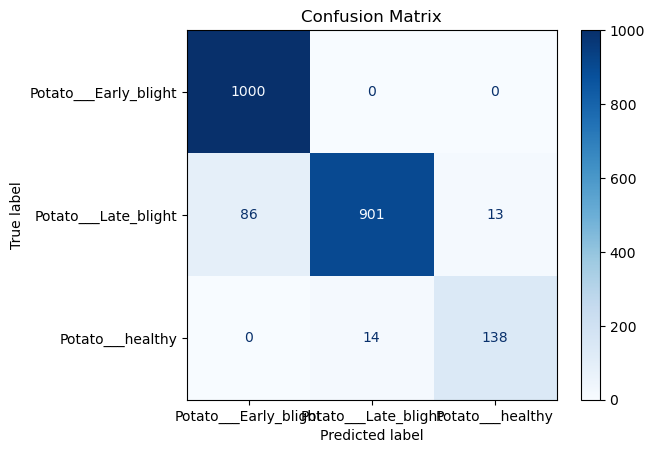

In [13]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()